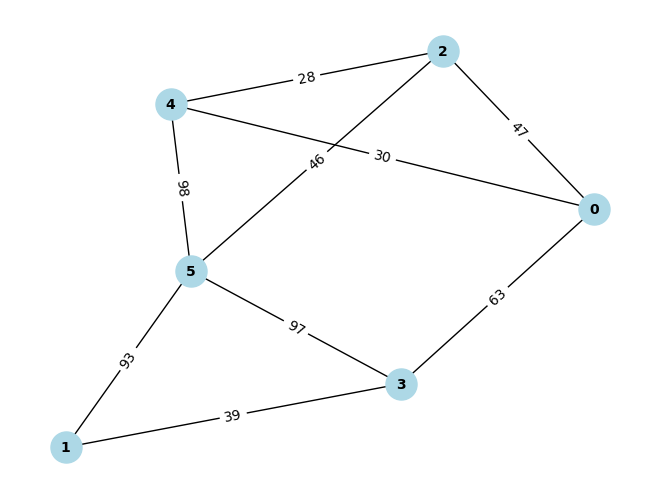

{0: Vehicle(id=0, time=0, into_city=0, intercity=5, decision=2, battery=13538.844234154476),
 1: Vehicle(id=1, time=0, into_city=0, intercity=0, decision=2, battery=2710.514013487144),
 2: Vehicle(id=2, time=0, into_city=0, intercity=1, decision=2, battery=916.6333836982953),
 3: Vehicle(id=3, time=0, into_city=0, intercity=0, decision=2, battery=10172.161980423474),
 4: Vehicle(id=4, time=0, into_city=0, intercity=3, decision=2, battery=15796.518517572677),
 5: Vehicle(id=5, time=0, into_city=0, intercity=1, decision=2, battery=1485.0952061122878),
 6: Vehicle(id=6, time=0, into_city=0, intercity=5, decision=2, battery=5045.9041034842085),
 7: Vehicle(id=7, time=0, into_city=0, intercity=4, decision=2, battery=15026.527371298138),
 8: Vehicle(id=8, time=0, into_city=0, intercity=2, decision=2, battery=8605.84670160353),
 9: Vehicle(id=9, time=0, into_city=0, intercity=2, decision=2, battery=4505.849643973054)}

In [54]:
from gurobipy import *
from typing import Dict
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import RL
import importlib
import tool_func

num_vehicle = 10
num_order = 100
num_city = 6
CAPACITY = 7
row = [100, 3, 1, 100]
Vehicles ={}
revenue_vector=[]
penalty_vector=[]


# 创建矩阵
matrix = np.tile(row, (num_vehicle, 1))
Vehicles = vehicle_generator(num_vehicle, num_city)
orders_unmatched = {}
G = CityGraph(num_city,0.3, (20,100))
name = "navie"
group = [list(range(0, num_vehicle-1)),list(range(num_vehicle-1, num_vehicle))]
Orders, revenue_vector, penalty_vector = order_generator(num_order, 0, num_city-1,CAPACITY ,10,G)

for order in Orders.values():
    orders_unmatched[order.id] = order
orders_virtual = orders_unmatched
city_node = city_node_generator(G,orders_virtual,Vehicles,orders_unmatched)
Vehicles

In [1]:
# order_virtual = RL.allocate(orders_unmatched) #此处强化学习

temp_Lower_Layer = Lower_Layer(num_vehicle, len(orders_unmatched), G, 
                            city_node ,Vehicles, orders_unmatched ,name,group)
temp_Lower_Layer.get_decision()
temp_Lower_Layer.constrain_1()
temp_Lower_Layer.constrain_2()
temp_Lower_Layer.constrain_3()
temp_Lower_Layer.constrain_4()
temp_Lower_Layer.constrain_5()

temp_Lower_Layer.set_objective(matrix, revenue_vector, penalty_vector)
temp_Lower_Layer.model.optimize()
if temp_Lower_Layer.model.status == GRB.OPTIMAL:
    # 打印变量的最优值
    print("Optimal solution:")
    i = 0
    with open(f"output_{1}.txt", "w") as file:
        for v in temp_Lower_Layer.model.getVars():
            # 更新信息
            if v.x == 1:
                file.write(f"{v.varName} = {v.x}\n")  # 将结果写入文件
        # 打印目标函数值
    print("Objective value:", temp_Lower_Layer.model.objVal)
    
    #RL.reward(temp_Lower_Layer.model.objVal)#此处返回给强化学习
    #update(temp_Lower_Layer.model.getVars(),t)
elif temp_Lower_Layer.model.status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    temp_Lower_Layer.model.computeIIS()  # 计算不可行约束
    temp_Lower_Layer.model.write("infeasible_constraints.ilp")  # 将 IIS 写入文件

    # 打印 IIS 信息
    print("\nThe following constraints are infeasible:")
    for c in temp_Lower_Layer.model.getConstrs():
        if c.IISConstr:  # 标记为不可行约束
            print(f"{c.constrName} is infeasible.")

else:
    print("No optimal solution found.")

NameError: name 'Lower_Layer' is not defined

In [56]:
if temp_Lower_Layer.model.status == GRB.OPTIMAL:
    # 打印变量的最优值
    print("Optimal solution:")
    i = 0
    changed_vehicle = []
    delet_list = []
    for v in temp_Lower_Layer.model.getVars():
       
        # 按下标获取车辆
        if i < 4 * num_vehicle:
            
            # 对于dispatching
            if i%4 == 0:
                Vehicles[i//4].update_time()
                if v.x == 1.0:
                    Vehicles[i//4].update_state(0) 
                    # 前往的城市在订单的迭代中修改
            # 对于charging
            if i%4 == 1:
                if v.x == 1.0:
                    Vehicles[i//4].update_state(1)
            # 对于idle
            if i%4 == 2:
                if v.x == 1.0:
                    Vehicles[i//4].update_state(2)
        else:
            
            
            # 如果该订单被匹配
            if v.x == 1.0:
                order_temp = Orders[(i - 4 * num_vehicle) // num_vehicle] 
                vehicle_temp = Vehicles[(i - 4 * num_vehicle) % num_vehicle]
                
                # 添加此订单并修改目标城市
                delet_list.append(order_temp.id)
                # 在此添加车辆ID

                # 添加订单和车辆匹配
                vehicle_temp.add_order(order_temp)
                order_temp.match_vehicle(vehicle_temp.id)
                # 只有当车辆ID不在changed_vehicle中时，才会执行以下操作
                if vehicle_temp.id not in changed_vehicle:
                    
                    if order_temp.virtual_departure != order_temp.departure:
                        vehicle_temp.move_to_city(order_temp.virtual_departure)
                    else:
                        _, path = G.get_intercity_path(*order_temp.route())
                        
                        vehicle_temp.move_to_city(path[1])
                        
                changed_vehicle.append(vehicle_temp.id)
        i+=1
                
               
        
    for order_id in delet_list:
        del orders_unmatched[order_id]
print(changed_vehicle)
print(delet_list)


Optimal solution:
[3, 0, 6, 5, 2, 7, 8, 1, 4, 1, 2, 7, 4, 0, 5, 8, 1, 2, 8, 7, 0, 0, 7, 3, 7, 1, 6, 1, 1, 5]
[4, 5, 9, 10, 14, 15, 17, 18, 19, 24, 26, 28, 35, 38, 40, 48, 60, 69, 72, 73, 78, 79, 80, 82, 86, 89, 92, 94, 96, 98]


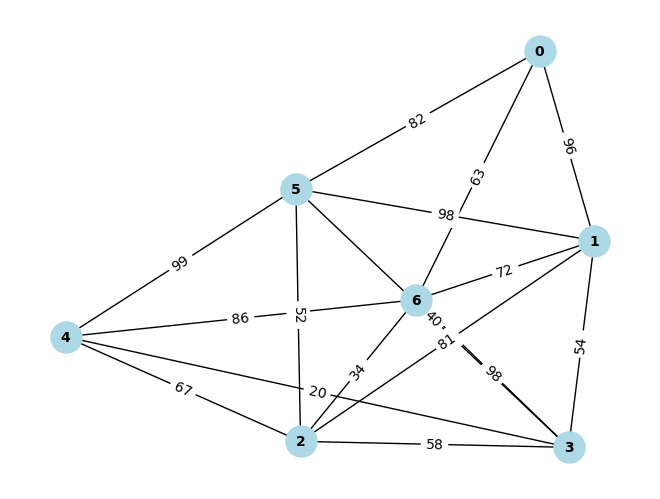

Set parameter LicenseID to value 2584673


INFO:gurobipy:Set parameter LicenseID to value 2584673


822.6434750694037
546.4278923516189
521.0237434149813
201.24966369168743
605.013836097096
408.28671294392456
6
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]


Thread count: 12 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 12 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 424 rows, 680 columns and 2427 nonzeros


INFO:gurobipy:Optimize a model with 424 rows, 680 columns and 2427 nonzeros


Model fingerprint: 0x7dd9086d


INFO:gurobipy:Model fingerprint: 0x7dd9086d


Model has 600 quadratic objective terms


INFO:gurobipy:Model has 600 quadratic objective terms


Variable types: 0 continuous, 680 integer (680 binary)


INFO:gurobipy:Variable types: 0 continuous, 680 integer (680 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 7e+00]


INFO:gurobipy:  Matrix range     [1e+00, 7e+00]


  Objective range  [1e+00, 4e+01]


INFO:gurobipy:  Objective range  [1e+00, 4e+01]


  QObjective range [4e+03, 3e+04]


INFO:gurobipy:  QObjective range [4e+03, 3e+04]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+01]


INFO:gurobipy:  RHS range        [1e+00, 1e+01]


Found heuristic solution: objective -68.0000000


INFO:gurobipy:Found heuristic solution: objective -68.0000000


Presolve removed 324 rows and 123 columns


INFO:gurobipy:Presolve removed 324 rows and 123 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 637 rows, 1094 columns, 3316 nonzeros


INFO:gurobipy:Presolved: 637 rows, 1094 columns, 3316 nonzeros


Found heuristic solution: objective -50.0000000


INFO:gurobipy:Found heuristic solution: objective -50.0000000


Variable types: 0 continuous, 1094 integer (1094 binary)


INFO:gurobipy:Variable types: 0 continuous, 1094 integer (1094 binary)


INFO:gurobipy:


Root relaxation: objective 2.058037e+05, 1596 iterations, 0.01 seconds (0.02 work units)


INFO:gurobipy:Root relaxation: objective 2.058037e+05, 1596 iterations, 0.01 seconds (0.02 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 205803.738    0  524  -50.00000 205803.738      -     -    0s


INFO:gurobipy:     0     0 205803.738    0  524  -50.00000 205803.738      -     -    0s


H    0     0                    205644.00000 205803.738  0.08%     -    0s


INFO:gurobipy:H    0     0                    205644.00000 205803.738  0.08%     -    0s


H    0     0                    205653.00000 205722.052  0.03%     -    0s


INFO:gurobipy:H    0     0                    205653.00000 205722.052  0.03%     -    0s


     0     0 205689.298    0  397 205653.000 205689.298  0.02%     -    0s


INFO:gurobipy:     0     0 205689.298    0  397 205653.000 205689.298  0.02%     -    0s


     0     0 205689.298    0  243 205653.000 205689.298  0.02%     -    0s


INFO:gurobipy:     0     0 205689.298    0  243 205653.000 205689.298  0.02%     -    0s


     0     0 205689.298    0  271 205653.000 205689.298  0.02%     -    0s


INFO:gurobipy:     0     0 205689.298    0  271 205653.000 205689.298  0.02%     -    0s


INFO:gurobipy:


Cutting planes:


INFO:gurobipy:Cutting planes:


  Gomory: 16


INFO:gurobipy:  Gomory: 16


  Cover: 24


INFO:gurobipy:  Cover: 24


  Implied bound: 1


INFO:gurobipy:  Implied bound: 1


  Clique: 140


INFO:gurobipy:  Clique: 140


  MIR: 16


INFO:gurobipy:  MIR: 16


  StrongCG: 8


INFO:gurobipy:  StrongCG: 8


  Zero half: 6


INFO:gurobipy:  Zero half: 6


  RLT: 23


INFO:gurobipy:  RLT: 23


  BQP: 369


INFO:gurobipy:  BQP: 369


INFO:gurobipy:


Explored 1 nodes (3281 simplex iterations) in 0.30 seconds (0.25 work units)


INFO:gurobipy:Explored 1 nodes (3281 simplex iterations) in 0.30 seconds (0.25 work units)


Thread count was 16 (of 16 available processors)


INFO:gurobipy:Thread count was 16 (of 16 available processors)


INFO:gurobipy:


Solution count 4: 205653 205644 -50 -68 


INFO:gurobipy:Solution count 4: 205653 205644 -50 -68 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 2.056530000000e+05, best bound 2.056605053733e+05, gap 0.0036%


INFO:gurobipy:Best objective 2.056530000000e+05, best bound 2.056605053733e+05, gap 0.0036%


Optimal solution:
Objective value: 205653.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
0个订单未被匹配


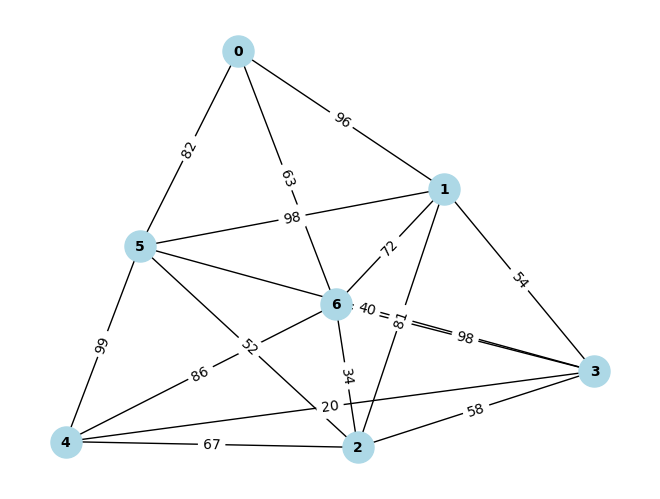

822.6434750694037
Order(id=1, passengers=3, departure=4, destination=2, matched_vehicle_id=6,battery=674.2944411632452, status=Matched)
[4, 2]
Order(id=8, passengers=4, departure=2, destination=3, matched_vehicle_id=6,battery=588.7284559031647, status=Matched)
[2, 3]


ValueError: 2 is not in list

In [1]:
from gurobipy import *
from typing import Dict
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import RL
import importlib
import tool_func
from update import *

num_vehicle = 20
num_order = 30
num_city = 7
TIME = 24
CAPACITY = 7
row = [10, 3, 1, 10]
Vehicles ={}
speed = 20
cancel_penalty = 300
battery_consume = 10
battery_add = 300
speed = 200
revenue_vector=[]
penalty_vector=[]
matrix = np.tile(row, (num_vehicle, 1))

# 初始化
Vehicles = vehicle_generator(num_vehicle, num_city)
orders_unmatched = {}
G = CityGraph(num_city,0.3, (20,100))
name = "navie"
cancel_penalty = 300
order_canceled = 0

for time in range(TIME):
    group = [[],[]]
    for vehicle in Vehicles.values():
        if vehicle.decision == 3:
            group[1].append(vehicle.id)
        else:
            group[0].append(vehicle.id)
    if len(group[0]) == 0:
        continue
    Orders, revenue_vector, penalty_vector = order_generator(num_order, time, num_city-1,CAPACITY,G)
    for order in Orders.values():
        orders_unmatched[order.id] = order

    orders_virtual = orders_unmatched
    if time == 0:
        city_node = city_node_generator(G,orders_virtual,Vehicles,orders_unmatched)
    # order_virtual = RL.allocate(orders_unmatched) #此处强化学习

    temp_Lower_Layer = Lower_Layer(G,city_node ,Vehicles, orders_unmatched ,name,group,time)
    temp_Lower_Layer.get_decision()
    temp_Lower_Layer.constrain_1()
    temp_Lower_Layer.constrain_2()
    temp_Lower_Layer.constrain_3()
    temp_Lower_Layer.constrain_4()
    temp_Lower_Layer.constrain_5()

    total_penalty = cancel_penalty*order_canceled
    temp_Lower_Layer.set_objective(matrix, revenue_vector, penalty_vector,total_penalty)
    temp_Lower_Layer.model.optimize()
    if temp_Lower_Layer.model.status == GRB.OPTIMAL:
        # 打印变量的最优值
        print("Optimal solution:")
        i = 0
        with open(f"output_{time}.txt", "w") as file:
            for v in temp_Lower_Layer.model.getVars():
                if v.x == 1:
                    file.write(f"{v.varName} = {v.x}\n")  # 将结果写入文件
            # 打印目标函数值
        print("Objective value:", temp_Lower_Layer.model.objVal)
        
        
    else:
        print("No optimal solution found.")
    _,var_order = temp_Lower_Layer.get_decision()
    update_var(temp_Lower_Layer, Vehicles,Orders,orders_unmatched)
    update_vehicle(Vehicles,battery_consume, battery_add, speed, city_node)
    order_canceled = update_order(orders_unmatched,time,speed)
    print(f"{len(orders_unmatched)}个订单未被匹配")
    